In [571]:
import os

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import graphviz

tqdm.pandas()

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 1: Load the data</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Dataset Metadata</div>

### Overview

The dataset contains metadata about characters from *A Song of Ice and Fire*, including house allegiance, gender, nobility, appearances across books, and death-related information. Each row represents a single character.

All death-related columns may contain missing values if the character is alive.

---

### Data Dictionary

| Variable           | Definition                          | Key                                                      |
|--------------------|-------------------------------------|----------------------------------------------------------|
| Name               | Character name                      | Text                                                     |
| Allegiances        | Character house                     | Categorical; e.g., "Wildling", "Night's Watch"           |
| Death Year         | Year character died                 | Integer or NaN (alive)                                   |
| Book of Death      | Book character died                 | 1 = GoT, 2 = CoK, 3 = SoS, 4 = FfC, 5 = DwD; NaN = Alive |
| Death Chapter      | Chapter in which the character died | Integer or NaN                                           |
| Book Intro Chapter | Chapter character was introduced in | Integer                                                  |
| Gender             | Gender                              | 1 = Male, 0 = Female                                     |
| Nobility           | Social class                        | 1 = Noble, 0 = Commoner                                  |
| GoT                | Appeared in *A Game of Thrones*     | 1 = Yes, 0 = No                                          |
| CoK                | Appeared in *A Clash of Kings*      | 1 = Yes, 0 = No                                          |
| SoS                | Appeared in *A Storm of Swords*     | 1 = Yes, 0 = No                                          |
| FfC                | Appeared in *A Feast for Crows*     | 1 = Yes, 0 = No                                          |
| DwD                | Appeared in *A Dance with Dragons*  | 1 = Yes, 0 = No                                          |

---

### Variable Notes

- **Allegiances**: This field contains the name of the house or faction a character belongs to. Some characters may have no allegiance specified.

- **Death Year**, **Book of Death**, **Death Chapter**: These columns are used to identify whether a character died, when, and where in the storyline. Missing values typically mean the character is still alive.

- **Book Intro Chapter**: Indicates the chapter in which the character first appeared.

- **GoT**, **CoK**, **SoS**, **FfC**, **DwD**: Binary indicators of whether the character appears in the corresponding book.

- **Gender** and **Nobility**: Represent demographic and social status attributes of the characters. These are already encoded as binary features.

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Load the data and display head</div>

In [572]:
# Check environment if in Kaggle
extract_folder_path = '/kaggle/input/topic-test' if os.path.exists('/kaggle/input/topic-test') else './data'

# Load the training data
train_file_path = os.path.join(extract_folder_path, 'train.csv')
train_data = pd.read_csv(train_file_path)

# Displaying the first few rows of the dataset
train_data.head()

,Character,Name,Allegiances,Death Year,Book of Death,Death Chapter,Book Intro Chapter,Gender,Nobility,GoT,CoK,SoS,FfC,DwD
0,155,Creighton Longbough,NaN,NaN,NaN,NaN,4.0,1,0,0,0,0,1,0
1,362,Howd Wanderer,Wildling,NaN,NaN,NaN,58.0,1,1,0,0,0,0,1
2,868,Watt,Night's Watch,299.0,3.0,75.0,69.0,1,0,0,0,1,0,0
3,101,Borcas,Night's Watch,NaN,NaN,NaN,48.0,1,0,1,0,0,0,0
4,199,Donnis,House Stark,NaN,NaN,NaN,7.0,1,0,1,0,0,0,0


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">See the statistical summary of the dataset</div>

In [573]:
train_data.describe()

,Character,Death Year,Book of Death,Death Chapter,Book Intro Chapter,Gender,Nobility,GoT,CoK,SoS,FfC,DwD
count,687.000000,243.000000,245.000000,239.000000,676.000000,687.000000,687.000000,687.000000,687.000000,687.000000,687.000000,687.000000
mean,461.184862,299.164609,2.963265,39.167364,28.766272,0.850073,0.454148,0.282387,0.352256,0.429403,0.264920,0.276565
std,265.290576,0.702462,1.334703,20.313231,19.795064,0.357260,0.498256,0.450489,0.478021,0.495352,0.441612,0.447625
min,0.000000,297.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,225.500000,299.000000,2.000000,23.500000,12.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,466.000000,299.000000,3.000000,37.000000,28.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,692.500000,300.000000,4.000000,56.000000,42.250000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,916.000000,300.000000,5.000000,77.000000,80.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [574]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687 entries, 0 to 686
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Character           687 non-null    int64  
 1   Name                687 non-null    object 
 2   Allegiances         502 non-null    object 
 3   Death Year          243 non-null    float64
 4   Book of Death       245 non-null    float64
 5   Death Chapter       239 non-null    float64
 6   Book Intro Chapter  676 non-null    float64
 7   Gender              687 non-null    int64  
 8   Nobility            687 non-null    int64  
 9   GoT                 687 non-null    int64  
 10  CoK                 687 non-null    int64  
 11  SoS                 687 non-null    int64  
 12  FfC                 687 non-null    int64  
 13  DwD                 687 non-null    int64  
dtypes: float64(4), int64(8), object(2)
memory usage: 75.3+ KB


We find out that some columns are 'object' type, which means they are categorical variables. We will need to convert them into numerical format before feeding them into the model.

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 2: Preprocess the data</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Separating features and target variable</div>

In [575]:
# Creating the binary target column
train_data['isDead'] = train_data[['Death Year','Book of Death','Death Chapter']].notna().any(axis=1).astype(int)

# Separating the features and the target variable
X = train_data.drop(columns=[
    'isDead', 'Character', 'Name', 'Death Year', 'Book of Death', 'Death Chapter'
])
y = train_data['isDead']

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Preprocessing the data</div>

For preprocessing, we will replace all missing values with `0` as required by the assignment instructions. Then, we will convert the `Allegiances` column into multiple dummy variables using one-hot encoding. This allows the model to handle categorical data in a numerical format suitable for training.

In [576]:
# Replace NaN with 0 for all numeric columns as required
X = X.fillna(0)

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns

# Convert all categorical columns to string to avoid mixed types error
X[categorical_cols] = X[categorical_cols].astype(str)

# Preprocessing for numerical data (no imputation needed since already filled with 0)
numerical_transformer = 'passthrough'

# Preprocessing for categorical data (only Allegiances needs one-hot encoding)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply preprocessing to the feature matrix
X_preprocessed = preprocessor.fit_transform(X)

# Display the first 5 rows of the transformed feature matrix
X_preprocessed[0:5]

array([[ 4.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [58.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.],
       [69.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.],
       [48.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.],
       [ 7.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.]])

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 3: Train the model</div>

<div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Splitting the data into training and validation sets</div>

In [577]:
# Split data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Print the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_valid shape: {y_valid.shape}")

X_train shape: (515, 9)
X_valid shape: (172, 9)
y_train shape: (515,)
y_valid shape: (172,)


<div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Training the DecisionTreeClassifier model</div>

In [578]:
# Define the Decision Tree model
dt_model = DecisionTreeClassifier(max_depth=4, random_state=42)

# Create and evaluate the pipeline
dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', dt_model)])

# Preprocessing of training data, fit model
dt_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get probability predictions
valid_probs = dt_pipeline.predict_proba(X_valid)

# Extracting the probabilities for the positive class
valid_positive_probs = valid_probs[:, 1]

# Evaluate the model using AUC
auc_score = roc_auc_score(y_valid, valid_positive_probs)
auc_score

0.6992668621700879

<div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Evaluating the Decision Tree model with confusion matrix, precision, recall, and accuracy</div>

In [579]:
# Make predictions on the validation set
y_pred = dt_pipeline.predict(X_valid)

# Compute confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# Compute precision, recall, accuracy
precision = precision_score(y_valid, y_pred, zero_division=0)
recall = recall_score(y_valid, y_pred, zero_division=0)
accuracy = accuracy_score(y_valid, y_pred)

# Print evaluation metrics
print(f"Confusion Matrix:\n{cm}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"Accuracy:  {accuracy:.4f}")

Confusion Matrix:
[[80 30]
 [26 36]]
Precision: 0.5455
Recall:    0.5806
Accuracy:  0.6744


<div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Visualizing the decision tree</div>

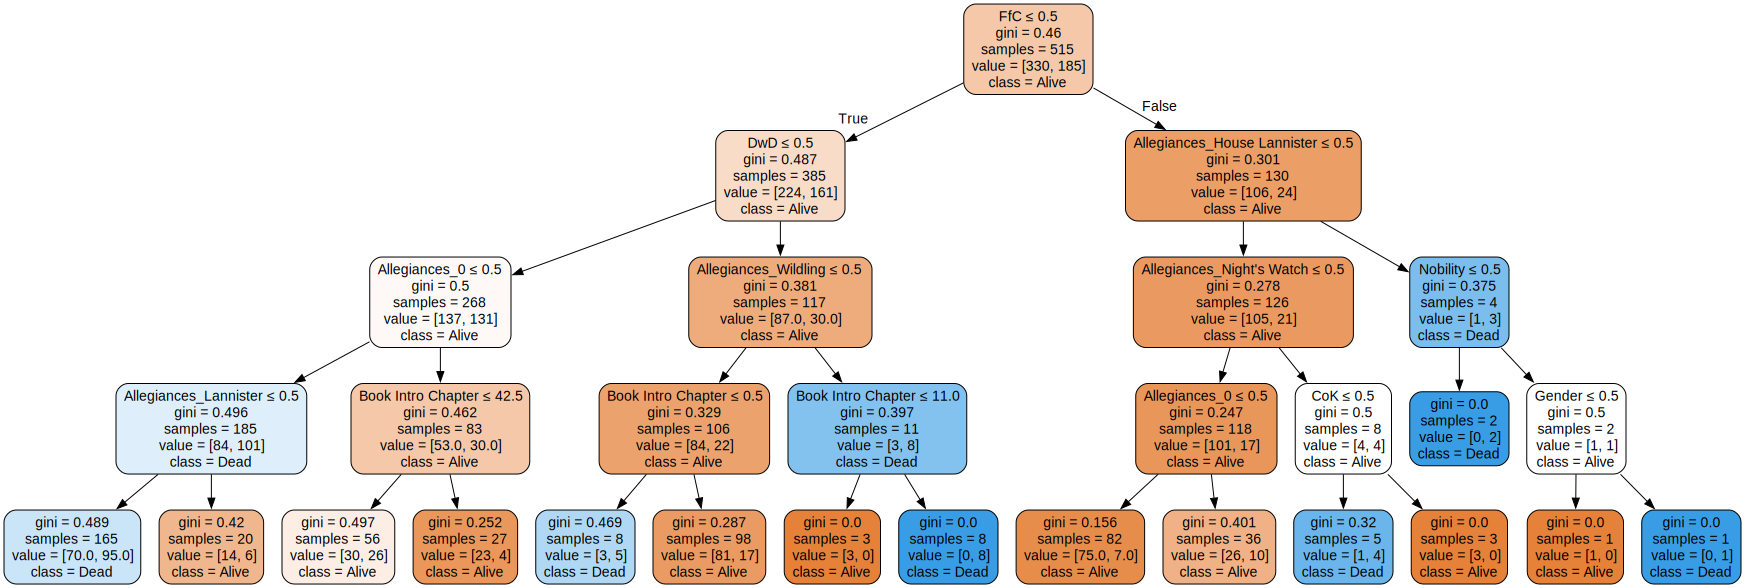

In [580]:
# Extract fitted OneHotEncoder from the full pipeline
fitted_ohe = dt_pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot']

# Extract feature names after one-hot encoding
ohe_feature_names = fitted_ohe.get_feature_names_out(categorical_cols)

# Combine numerical and categorical (one-hot) feature names
feature_names = list(numerical_cols) + list(ohe_feature_names)

# Extract fitted decision tree model from pipeline
dt_model = dt_pipeline.named_steps['model']

# Export tree to DOT format
dot_data = export_graphviz(
    dt_model,
    out_file=None,
    feature_names=feature_names,
    class_names=['Alive', 'Dead'],
    filled=True,
    rounded=True,
    special_characters=True
)

# Export and save the tree as PNG
graph = graphviz.Source(dot_data, engine="dot")
if os.path.exists('plot/'):
    png_bytes = graph.pipe(format="png")
    with open("plot/tree.png", "wb") as f:
        f.write(png_bytes)
graph

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 4: Randomized Search Cross Validation</div>

<div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Hyperparameter Tuning with Randomized Search CV</div>

Sometimes, the default parameters of a model may not yield the best performance. To optimize the model's performance, we can use techniques like Randomized Search Cross-Validation to find the best hyperparameters.

In [581]:
# Define the parameter grid for DecisionTreeClassifier (focused on accuracy)
param_grid = {
    'model__max_depth': list(range(3, 13)),
    'model__min_samples_split': [2, 5, 10, 20],
    'model__min_samples_leaf': [2, 5, 10],
    'model__max_leaf_nodes': [None, 16, 32, 64],
    'model__max_features': [None, 'sqrt', 0.5],
    'model__criterion': ['gini', 'entropy'],
    'model__ccp_alpha': np.linspace(0.0, 0.006, 7),
    'model__class_weight': [None]
}

# Define StratifiedKFold for consistent splits
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the randomized search with 10-fold cross-validation
dt_random_search = RandomizedSearchCV(
    estimator=dt_pipeline,
    param_distributions=param_grid,
    n_iter=40,
    scoring='accuracy',
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit the random search model
dt_random_search.fit(X_train, y_train)

# Best parameters and score
best_params = dt_random_search.best_params_
best_score = dt_random_search.best_score_

best_params, best_score

Fitting 5 folds for each of 40 candidates, totalling 200 fits


({'model__min_samples_split': 20,
  'model__min_samples_leaf': 5,
  'model__max_leaf_nodes': 32,
  'model__max_features': 0.5,
  'model__max_depth': 9,
  'model__criterion': 'entropy',
  'model__class_weight': None,
  'model__ccp_alpha': np.float64(0.001)},
 np.float64(0.6873786407766991))

<div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Evaluating the best hyperparameters performance</div>

In [582]:
# Define the tuned Decision Tree model
dt_model_tuned = DecisionTreeClassifier(
    max_depth=best_params['model__max_depth'],
    min_samples_split=best_params['model__min_samples_split'],
    min_samples_leaf=best_params['model__min_samples_leaf'],
    max_leaf_nodes=best_params['model__max_leaf_nodes'],
    max_features=best_params['model__max_features'],
    criterion=best_params['model__criterion'],
    ccp_alpha=best_params['model__ccp_alpha'],
    class_weight=best_params['model__class_weight'],
    random_state=42
)

# Update the pipeline
dt_pipeline.set_params(model=dt_model_tuned)

# Fit the model with the training data
dt_pipeline.fit(X_train, y_train)

# Predict probabilities on the validation set
valid_probs_tuned = dt_pipeline.predict_proba(X_valid)

# Extracting the probabilities for the positive class
valid_positive_probs_tuned = valid_probs_tuned[:, 1]

# Evaluate the tuned model using AUC
auc_score_tuned = roc_auc_score(y_valid, valid_positive_probs_tuned)
auc_score_tuned

0.7065982404692082

<div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Comparing accuracy scores before and after tuning</div>

In [583]:
# Display Accuracy before (from earlier eval) and after tuning
print(f"Accuracy before tuning: {accuracy:.4f}")

y_pred_tuned_tmp = dt_pipeline.predict(X_valid)
accuracy_tuned_tmp = accuracy_score(y_valid, y_pred_tuned_tmp)
print(f"Accuracy after tuning:  {accuracy_tuned_tmp:.4f}")

Accuracy before tuning: 0.6744
Accuracy after tuning:  0.6919


<div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Evaluating the tuned Decision Tree model with confusion matrix, precision, recall, and accuracy</div>

In [584]:
# Make predictions on the validation set
y_pred = dt_pipeline.predict(X_valid)

# Compute confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# Compute precision, recall, accuracy
precision = precision_score(y_valid, y_pred, zero_division=0)
recall = recall_score(y_valid, y_pred, zero_division=0)
accuracy = accuracy_score(y_valid, y_pred)

# Print evaluation metrics
print(f"Confusion Matrix:\n{cm}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"Accuracy:  {accuracy:.4f}")

Confusion Matrix:
[[88 22]
 [31 31]]
Precision: 0.5849
Recall:    0.5000
Accuracy:  0.6919


<div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Visualizing the tuned decision tree</div>

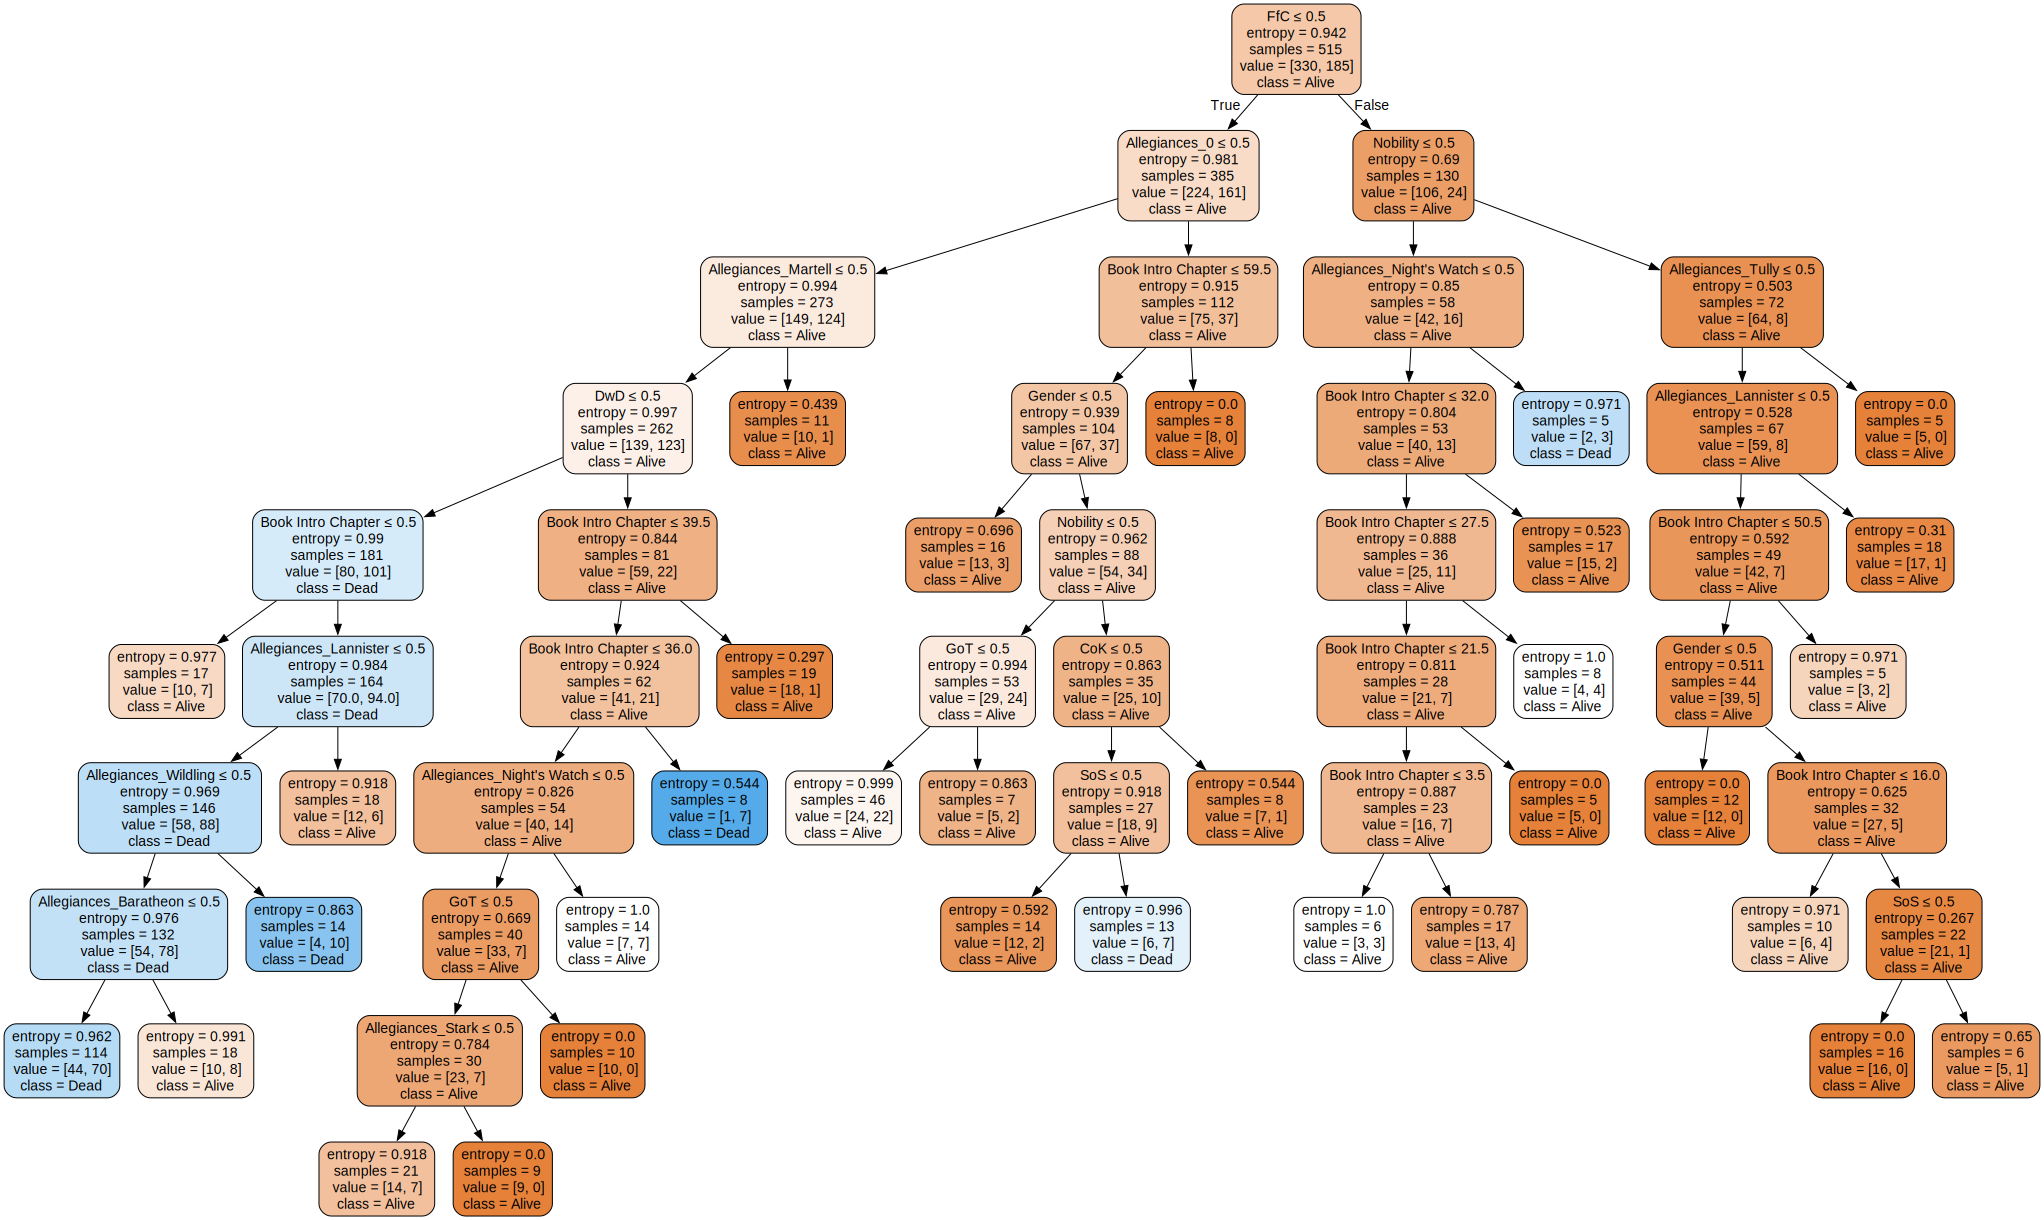

In [585]:
# Extract fitted OneHotEncoder from the full pipeline
fitted_ohe = dt_pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot']

# Extract feature names after one-hot encoding
ohe_feature_names = fitted_ohe.get_feature_names_out(categorical_cols)

# Combine numerical and categorical (one-hot) feature names
feature_names = list(numerical_cols) + list(ohe_feature_names)

# Extract fitted decision tree model from pipeline
dt_model = dt_pipeline.named_steps['model']

# Export tree to DOT format
dot_data = export_graphviz(
    dt_model,
    out_file=None,
    feature_names=feature_names,
    class_names=['Alive', 'Dead'],
    filled=True,
    rounded=True,
    special_characters=True
)

# Render the tree using Graphviz
graph = graphviz.Source(dot_data, engine="dot")
if os.path.exists('plot/'):
    png_bytes = graph.pipe(format="png")
    with open("plot/tree_tuned.png", "wb") as f:
        f.write(png_bytes)
graph

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 5: Make predictions on the test set</div>

<div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Create the submission file and check the format</div>

In [586]:
# Load the test dataset
test_data_path = os.path.join(extract_folder_path, 'test.csv')
test_data = pd.read_csv(test_data_path)

# Build test features to match training
test_X = test_data.drop(columns=['Character', 'Name'], errors='ignore')
test_X = test_X.fillna(0)
test_X[categorical_cols] = test_X[categorical_cols].astype(str)

# Preprocessing of test data, make predictions
test_predictions = dt_pipeline.predict(test_X)  # 0 = Alive, 1 = Dead

# Load the sample submission file to compare formats
sample_submission_path = os.path.join(extract_folder_path, 'sample_submission.csv')
sample_submission = pd.read_csv(sample_submission_path)

# Create the submission DataFrame
submission = pd.DataFrame({
    'Character': test_data['Character'],
    'Death': test_predictions.astype(int)
})

# See if the submission format matches the sample submission
print('Submission shape:', submission.shape)
print('Sample submission shape:', sample_submission.shape)

print('submission head:')
print(submission.head())

print('sample submission head:')
print(sample_submission.head())

Submission shape: (230, 2)
Sample submission shape: (230, 2)
submission head:
   Character  Death
0        668      1
1         30      1
2        377      0
3        535      0
4        806      0
sample submission head:
   Character  Death
0        668      0
1         30      1
2        377      0
3        535      1
4        806      1


<div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Save the submission file</div>

In [587]:
# Define the file path for the output CSV file
output_csv_path = 'submission.csv'

# Save the output DataFrame to a CSV file
submission.to_csv(output_csv_path, index=False)

# Return the path of the saved file
output_csv_path

'submission.csv'